In [1]:
import requests
import pandas as pd

r = requests.get("https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative")
f = open('planet_data.csv', 'w')
f.write(r.text)
df = pd.read_csv('planet_data.csv')
# df.describe()
df

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra_str,dec_str,koi_kepmag,koi_kepmag_err
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,19h27m44.22s,+48d08m29.9s,15.347,NaN
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,19h27m44.22s,+48d08m29.9s,15.347,NaN
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,19h48m01.16s,+48d08m02.9s,15.436,NaN
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,19h02m08.31s,+48d17m06.8s,15.597,NaN
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,19h15m01.17s,+48d13m34.3s,15.509,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,NaN,NaN,4500.53,3406.38,-1175.26,453.3,1.0,q1_q17_dr25_tce,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,19h48m45.30s,+47d05m37.7s,14.082,NaN
9560,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,NaN,NaN,1585.81,1537.86,-502.22,10.6,1.0,q1_q17_dr25_tce,6119.0,165.0,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,19h06m02.25s,+47d09m47.6s,14.757,NaN
9561,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,0,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,NaN,NaN,5713.41,5675.74,-1836.94,12.3,1.0,q1_q17_dr25_tce,6173.0,193.0,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,19h36m39.57s,+47d10m34.6s,15.385,NaN
9562,10155286,K07988.01,NaN,CANDIDATE,CANDIDATE,0.092,0,0,0,0,333.486169,4.235000e-03,-4.235000e-03,153.615010,0.005070,-0.005070,0.214,0.255,-0.214,3.19900,0.22900,-0.22900,639.1,52.7,-52.7,19

In [ ]:
import numpy as np

def create_dataset(df, row):
  """ Converts string categories into numerical categories and splits the data into observations and corresponding classification
  :df: a pandas dataframe
  :row: features of interest
  """
    extracted_data = []

    confirmed = 0
    false_positive = 0
    candidate = 0

    for index, planet in df.iterrows():

        # attributes we care about
        disposition = planet.loc['koi_disposition'] # y data

        planet_info = []
        for attr in row:
            planet_info.append(planet.loc[attr])

        if disposition == 'CONFIRMED':
            confirmed += 1
            extracted_data.append((planet_info, 1))
        elif disposition == 'FALSE POSITIVE':
            false_positive += 1
            extracted_data.append((planet_info, 0))
        elif disposition == 'CANDIDATE':
            candidate += 1
            extracted_data.append((planet_info, -1))
        
    print(f'Number of confirmed planets: {confirmed}')
    print(f'Number of false positive instances: {false_positive}')
    print(f'Number of candidate planets: {candidate}')

    training_data = []
    deployment_data = []

    for planet in extracted_data:
        array = np.array(planet[0])
        if np.isnan(array).any():
            pass
        else:
            if planet[1] == -1:
                deployment_data.append(planet[0])
            else:
                training_data.append(planet)
                               
    return training_data, deployment_data

In [ ]:
import matplotlib.pyplot as plt

def plot_learning(results, epochs):
  """ Plots how our models learned using accuracy and loss
  :param results: object returned from fitting a tensorflow model
  :param epocs: number of epochs
  """
    acc = results.history['accuracy']
    val_acc = results.history['val_accuracy']

    loss = results.history['loss']
    val_loss = results.history['val_loss']

    epochs_range = range(epochs)

    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (% correct)')
    plt.show()

    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [ ]:
def five_fold(inputs, targets):
  """ A function that divides our input data into 5 subsets for cross validation
  :param inputs: transit observation
  :param targets: corresponding disposition
  """
    D_inputs = []
    t_targets = []
    D_dict = {'d1': [], 'd2': [], 'd3': [], 'd4': [], 'd5': []}
    t_target_dict = {'d1': [], 'd2': [], 'd3': [], 'd4': [], 'd5': []}

    for x in range(len(inputs)):
        D_dict['d' + str((x % 5) + 1)].append(inputs[x])
        t_target_dict['d' + str((x % 5) + 1)].append(targets[x])
    for k in D_dict.keys():
        D_inputs.append(np.array(D_dict[k]))
        t_targets.append(np.array(t_target_dict[k]))
    return D_inputs, t_targets

In [ ]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(clf, inputs, targets):
  """ returns the confusion matrix comparing predicted disposition with actual disposition
  :param clf: model for prediction
  :param inputs: observations
  :param targets: actual class
  """
    predictions = clf.predict(inputs)
    return confusion_matrix(predictions, targets)


In [ ]:
def calculate_metrics(tn, fp, fn, tp):
  """ calculates several metrics discussed in class using the output from get_confusion_matrix
  :param tn: # of true negative classifications
  :param fp: # of false positive classifications
  :param fn: # of false negative classifications
  :param tp: # of true positive classifications

  """
    accuracy = (tn + tp) / (tn + fp + fn + tp)
    error_rate = 1 - accuracy
    if tp == 0:
        precision = 0
        recall = 0
    else:
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
    
    if tn == 0:
        specificity = 0
    else:
        specificity = tn / (tn + fp)
    fp_rate = 1 - specificity
    fn_rate = 1 - recall

    metrics = {
        'accuracy': accuracy,
        'error_rate': 1 - accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'fp_rate': fp_rate,
        'fn_rate': fn_rate
    }

    return metrics

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, clone_model

def run_tf_model(X, y, model, epochs):
  """
  trains and a tensorflow neural network using five fold cross validation
  :param X: Matrix of predictors
  :param y: vector of response
  :param model: tensorflow model
  :param epochs: number of epochs
  """
    D, t = five_fold(X, y)

    scores = []
    best_model = (None, 0)
    tp_rates = []
    fp_rates = []
    for i in range(len(D)):
        testing_inputs = D[i]
        training_inputs = []
        testing_targets = t[i]
        training_targets = []
        for j in range(len(D)): # the other 4 groups are used for training
            if i != j:
                training_inputs.extend(D[j])
                training_targets.extend(t[j])
        training_inputs = np.array(training_inputs)
        training_targets = np.array(training_targets)

        training_successful = False
        while not training_successful:
            count_fp = 0
            for g in testing_targets:
                if g == 0:
                    count_fp += 1
            
            baseline = count_fp / len(testing_targets)
            new_model = clone_model(model)

            new_model.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

            model_results = new_model.fit(training_inputs, training_targets, validation_data=(testing_inputs, testing_targets), epochs=epochs, verbose=0)

            evaluation = new_model.evaluate(x=testing_inputs, y=testing_targets, verbose=0)
            score = evaluation[1]

            predictions = new_model.predict(testing_inputs)
            predictions.flatten()
            pred_class = [1 if p > 0.5 else 0 for p in predictions]

            conf_matrix = confusion_matrix(testing_targets, pred_class)
            tn, fp, fn, tp = conf_matrix.ravel()
            metrics = calculate_metrics(tn, fp, fn, tp)
            if score * 0.95 < baseline < score * 1.05:
                pass
            else:
                print(f'Model {i + 1}:\n\tAccuracy: {score}\n\tPrecision: {metrics["precision"]}\n\tRecall: {metrics["recall"]}\n')
                print(f"Confusion Matrix: [[{tp}, {fn}],")
                print(f"                   [{fp}, {tn}]]\n")
                
                plot_learning(model_results, epochs)

                tp_rates.append(metrics['recall'])
                fp_rates.append(metrics['fp_rate'])
                scores.append(score)

                if score > best_model[1]:
                    best_model = (new_model, score)
                
                training_successful = True

    print("ROC Curves")
    plt.scatter(fp_rates, tp_rates)
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("ROC Curve")
    plt.show()

    plt.scatter(fp_rates, tp_rates)
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.title("ROC Curve - Zoomed In")
    plt.show()

    return np.mean(scores), best_model


In [ ]:
import matplotlib.pyplot as plt


def test_model(Classifier, X, y, rf = None):
  """ tests sklearn models using five fold cross validation
  :param Classifier: an sklearn classifier object
  :param X: predictors
  :param y: response
  """
    D, t = five_fold(X, y)

    scores = []
    best_model = (None, 0)
    tp_rates = []
    fp_rates = []
    for i in range(len(D)):
        testing_inputs = D[i]
        training_inputs = []
        testing_targets = t[i]
        training_targets = []
        for j in range(len(D)): # the other 4 groups are used for training
            if i != j:
                training_inputs.extend(D[j])
                training_targets.extend(t[j])
        training_inputs = np.array(training_inputs)
        training_targets = np.array(training_targets)
        if rf is not None:
            clf = Classifier(n_estimators=rf['n_estimators'], max_depth=rf['max_depth'])
        else:
            clf = Classifier()
        clf.fit(training_inputs, training_targets)
        score = clf.score(testing_inputs, testing_targets)
        scores.append(score)

        cm = get_confusion_matrix(clf, testing_inputs, testing_targets)
        tn, fp, fn, tp = cm.ravel()
        metrics = calculate_metrics(tn, fp, fn, tp)
        print(f'Model {i + 1}:\n\tAccuracy: {score}\n\tPrecision: {metrics["precision"]}\n\tRecall: {metrics["recall"]}\n')
        print(f"Confusion Matrix: [[{tp}, {fn}],")
        print(f"                   [{fp}, {tn}]]\n")

        tp_rates.append(metrics['recall'])
        fp_rates.append(metrics['fp_rate'])

        if score > best_model[1]:
            best_model = (clf, score)

    print("ROC Curves")
    plt.scatter(fp_rates, tp_rates)
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("ROC Curve")
    plt.show()

    plt.scatter(fp_rates, tp_rates)
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.title("ROC Curve - Zoomed In")
    plt.show()

    return np.mean(scores), best_model

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

def five_fold_cross_validation(hidden_layer_sizes, inputs, targets, epochs=200, 
                               learning_rate=1e-3, plot_loss=False, verbose=False, 
                               light_verbose=False, show_conf_matrix=False):
  
    # caluclate the log loss for the classifer at each learning step
    def calculate_log_loss(mlp, inputs, targets):
        probabilities = mlp.predict_proba(inputs)
        prediction_probabilities = 0
        for y, y_hat in zip(targets, probabilities):
            if y == 1:
                p = np.log(y_hat[1])
            else:
                p = np.log(y_hat[0])
            prediction_probabilities += p
        return (-1 / len(targets)) * prediction_probabilities

    D, t = five_fold(inputs, targets)

    accuracies = [] # accuracies of each network
    overfitted = 0 # number of models that overfit
    
    best_model = (None, 0)

    tp_rates = []
    fp_rates = []

    for i in range(len(D)): # loop over the 5 classes
        testing_inputs = D[i] # use the ith group for validation
        training_inputs = []
        testing_targets = t[i]
        training_targets = []
        for j in range(len(D)): # the other 4 groups are used for training
            if i != j:
                training_inputs.extend(D[j])
                training_targets.extend(t[j])
        training_inputs = np.array(training_inputs)
        training_targets = np.array(training_targets)

        # create an MLP classifer
        mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate)

        training_loss = []
        testing_loss = []

        min_training_loss = np.inf
        min_testing_loss = np.inf

        # train the model for the number of epochs specified by the user (default is 200)
        for epoch in range(epochs):
            mlp.partial_fit(training_inputs, training_targets, [0, 1])    

            # calculate training loss
            train_loss = calculate_log_loss(mlp, training_inputs, training_targets)
            if train_loss < min_training_loss:
                min_training_loss = train_loss
            training_loss.append(train_loss)

            # calculate testing loss
            test_loss = calculate_log_loss(mlp, testing_inputs, testing_targets)
            if test_loss < min_testing_loss:
                min_testing_loss = test_loss
            testing_loss.append(test_loss)

        first_training_loss = training_loss[0]
        first_testing_loss = testing_loss[0]

        k = -1
        final_training_loss = training_loss[k]
        while np.isnan(final_training_loss):
            k -= 1
            final_training_loss = training_loss[k]

        k = -1
        final_testing_loss = testing_loss[k]
        while np.isnan(final_testing_loss):
            k -= 1
            final_testing_loss = testing_loss[k]

        # record network accuracy using the validation group
        accuracy = mlp.score(testing_inputs, testing_targets)
        accuracies.append(accuracy)

        if accuracy > best_model[1]:
            best_model = (mlp, accuracy)

        # print model accuracy
        # print(f"Accuracy of model {i + 1}: {accuracy}")

        # determine overfitting
        testing_loss_range = first_testing_loss - min_testing_loss
        final_testing_loss_range = first_testing_loss - final_testing_loss
        # if the final loss value is higher than the lowest loss value, then there was overfitting
        if 1 - (final_testing_loss_range / testing_loss_range) > 0.03:
            if verbose: print("Overfitting identified")
            overfitted += 1

        # generate the model confusion matrix
        if show_conf_matrix:
            cm = get_confusion_matrix(mlp, testing_inputs, testing_targets)
            tn, fp, fn, tp = cm.ravel()
            metrics = calculate_metrics(tn, fp, fn, tp)
            print(f'Model {i + 1}:\n\tAccuracy: {accuracy}\n\tPrecision: {metrics["precision"]}\n\tRecall: {metrics["recall"]}\n')
            print(f"Confusion Matrix: [[{tp}, {fn}],")
            print(f"                   [{fp}, {tn}]]\n")

        # plot the loss graphs
        if plot_loss:
            plt.plot(training_loss, label="Training Loss")
            plt.plot(testing_loss, label="Testing Loss")
            plt.xlabel("Number of Epochs")
            plt.ylabel("Log-Loss")
            plt.title("MLP Loss, Learning rate="+str(learning_rate))
            plt.legend()
            plt.show()

        tp_rates.append(metrics['recall'])
        fp_rates.append(metrics['fp_rate'])

    print("ROC Curves")
    plt.scatter(fp_rates, tp_rates)
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("ROC Curve")
    plt.show()

    plt.scatter(fp_rates, tp_rates)
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.title("ROC Curve - Zoomed In")
    plt.show()

    # return the average accuracy of the 5 networks
    return np.mean(accuracies), best_model

In [ ]:
def calculate_candidate_confidence(predictions):
  """ given outputted neural network predictions, count the number of classifications above certain levels of confidence. 
      medium confidence > .95, high > .99, and full > .999
      :param predictions: vector of predictions (value between 0 and 1)
  """
    medium_confidence = 0
    high_confidence = 0
    full_confidence = 0

    for p in predictions:
        if p > 0.95:
            medium_confidence += 1
        if p > 0.99:
            high_confidence += 1
        if p > 0.999:
            full_confidence += 1

    print(f'Medium confidence (above 95%) in {medium_confidence} planets')
    print(f'High confidence (above 99%) in {high_confidence} planets')
    print(f'Full confidence (above 99.9%) in {full_confidence} planets')


In [ ]:
from sklearn.tree import DecisionTreeClassifier

def run_tree_model(X, y):
  """ runs the decision tree classification algorithm
  :param X: predictors
  :param y: response
  """
    avg_score, best_model = test_model(DecisionTreeClassifier, X, y)

    return avg_score, best_model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def run_random_forest(X, y, forest_model):
  """ runs the random forest classification algorithm
  :param X: predictors
  :param y: response
  """
    avg_score, best_model = test_model(RandomForestClassifier, X, y, rf=forest_model)

    return avg_score, best_model

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def perform_pca(X, Y, percent=0.01):
  """ performs principal component analysis
  :param X: predictors
  :param y: response
  :param percent: percent of total points plotted
  """
    pca = PCA(n_components=2)

    pca.fit(X)
    pc1, pc2 = pca.components_

    xs = []
    ys = []
    i = 1
    for d, target in zip(X, Y):
        if i % (percent * 100) == 0:
            x = np.dot(d, pc1)
            y = np.dot(d, pc2)
            xs.append(x)
            ys.append(y)
            if target == 0:
                plt.plot(x, y, 'r.')
            if target == 1:
                plt.plot(x, y, 'g.')
        i += 1

    d = []
    for x, y in zip(xs, ys):
        d.append([x, y])

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA")
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def perform_pca3d(X, Y, percent=0.01):
  """ performs three dimensional principal component analysis
  :param X: predictors
  :param y: response
  :param percent: percent of total points plotted
  """
    pca = PCA(n_components=3)

    pca.fit(X)
    pc1, pc2, pc3 = pca.components_

    fig = plt.figure()
    fig.set_size_inches(7, 4)
    ax = fig.add_subplot(projection='3d')

    i = 0
    xs = []
    ys = []
    zs = []
    for d, target in zip(X, Y):
        if i % (percent * 100) == 0:
            x = np.dot(d, pc1)
            y = np.dot(d, pc2)
            z = np.dot(d, pc3)
            xs.append(x)
            ys.append(y)
            zs.append(z)
            if target == 0:
                ax.plot([x], [y], [z], 'r.')
            if target == 1:
                ax.plot([x], [y], [z], 'g.')
        i += 1

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    ax.set_title('3D PCA')

    plt.show()

    fig = plt.figure()
    fig.set_size_inches(7, 4)
    ax = fig.add_subplot(projection='3d')

    i = 0
    xs = []
    ys = []
    zs = []
    for d, target in zip(X, Y):
        if i % (percent * 100) == 0:
            x = np.dot(d, pc1)
            z = np.dot(d, pc2)
            y = np.dot(d, pc3)
            xs.append(x)
            ys.append(y)
            zs.append(z)
            if target == 0:
                ax.plot([x], [y], [z], 'r.')
            if target == 1:
                ax.plot([x], [y], [z], 'g.')
        i += 1

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC3')
    ax.set_zlabel('PC2')

    ax.set_title('3D PCA')

    plt.show()

    fig = plt.figure()
    fig.set_size_inches(7, 4)
    ax = fig.add_subplot(projection='3d')

    i = 0
    xs = []
    ys = []
    zs = []
    for d, target in zip(X, Y):
        if i % (percent * 100) == 0:
            y = np.dot(d, pc1)
            x = np.dot(d, pc2)
            z = np.dot(d, pc3)
            xs.append(x)
            ys.append(y)
            zs.append(z)
            if target == 0:
                ax.plot([x], [y], [z], 'r.')
            if target == 1:
                ax.plot([x], [y], [z], 'g.')
        i += 1

    ax.set_xlabel('PC2')
    ax.set_ylabel('PC1')
    ax.set_zlabel('PC3')

    ax.set_title('3D PCA')

    plt.show()

    fig = plt.figure()
    fig.set_size_inches(7, 4)
    ax = fig.add_subplot(projection='3d')

    i = 0
    xs = []
    ys = []
    zs = []
    for d, target in zip(X, Y):
        if i % (percent * 100) == 0:
            z = np.dot(d, pc1)
            y = np.dot(d, pc2)
            x = np.dot(d, pc3)
            xs.append(x)
            ys.append(y)
            zs.append(z)
            if target == 0:
                ax.plot([x], [y], [z], 'r.')
            if target == 1:
                ax.plot([x], [y], [z], 'g.')
        i += 1

    ax.set_xlabel('PC3')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC1')

    ax.set_title('3D PCA')

    plt.show()

    fig = plt.figure()
    fig.set_size_inches(7, 4)
    ax = fig.add_subplot(projection='3d')

    i = 0
    xs = []
    ys = []
    zs = []
    for d, target in zip(X, Y):
        if i % (percent * 100) == 0:
            y = np.dot(d, pc1)
            z = np.dot(d, pc2)
            x = np.dot(d, pc3)
            xs.append(x)
            ys.append(y)
            zs.append(z)
            if target == 0:
                ax.plot([x], [y], [z], 'r.')
            if target == 1:
                ax.plot([x], [y], [z], 'g.')
        i += 1

    ax.set_xlabel('PC3')
    ax.set_ylabel('PC1')
    ax.set_zlabel('PC2')

    ax.set_title('3D PCA')

    plt.show()

    fig = plt.figure()
    fig.set_size_inches(7, 4)
    ax = fig.add_subplot(projection='3d')

    i = 0
    xs = []
    ys = []
    zs = []
    for d, target in zip(X, Y):
        if i % (percent * 100) == 0:
            z = np.dot(d, pc1)
            x = np.dot(d, pc2)
            y = np.dot(d, pc3)
            xs.append(x)
            ys.append(y)
            zs.append(z)
            if target == 0:
                ax.plot([x], [y], [z], 'r.')
            if target == 1:
                ax.plot([x], [y], [z], 'g.')
        i += 1

    ax.set_xlabel('PC2')
    ax.set_ylabel('PC3')
    ax.set_zlabel('PC1')

    ax.set_title('3D PCA')

    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import heapq

def test_knn(X, y, kmin, kmax):
  """ runs the k-nearest neighbor algorithm for k = kmin:kmax
  :param X: predictors
  :param y: response (planet disposition)
  :param kmin: lowest value for k
  :param kmax: maximum value for k
  """
    D, t = five_fold(X, y)

    scores = {}
    tp_rates = {}
    fp_rates = {}

    for k in range(kmin, kmax + 1):
        scores[k] = []
        tp_rates[k] = []
        fp_rates[k] = []

    for i in range(len(D)):
        testing_inputs = D[i]
        training_inputs = []
        testing_targets = t[i]
        training_targets = []
        for j in range(len(D)): # the other 4 groups are used for training
            if i != j:
                training_inputs.extend(D[j])
                training_targets.extend(t[j])
        training_inputs = np.array(training_inputs)
        training_targets = np.array(training_targets)

        # perform KNN here
        # classify 'testing_inputs' using 'training_inputs'
        pred_class = {}
        for j in range(kmin, kmax + 1):
            pred_class[j] = []
        for point in testing_inputs: # for each test point
            heap = []
            for other,classification in zip(training_inputs,training_targets): # for every training point
                heap.append((np.linalg.norm(point - other), classification)) # add distance to heap, along with class
            heapq.heapify(heap)
            # classify for k = kmin to k = kmax to avoid repeated calls
            for k in range(kmin, kmax + 1):
                top_k = [heap[i][1] for i in range(k)] # get top k
                label = max(set(top_k), key=top_k.count) # get label of top k
                pred_class[k].append(label) # add label to predicted classes
            
        for k in range(kmin, kmax + 1):
            conf_matrix = confusion_matrix(pred_class[k], testing_targets)
            tn, fp, fn, tp = conf_matrix.ravel()
            metrics = calculate_metrics(tn, fp, fn, tp)
            score = metrics['accuracy']
            print(f'Model {i + 1}, k={k}:\n\tAccuracy: {score}\n\tPrecision: {metrics["precision"]}\n\tRecall: {metrics["recall"]}\n')
            print(f"Confusion Matrix: [[{tp}, {fn}],")
            print(f"                   [{fp}, {tn}]]\n")

            scores[k].append(score)
            tp_rates[k].append(metrics['recall'])
            fp_rates[k].append(metrics['fp_rate'])

    for k in range(kmin, kmax + 1):
        print("ROC Curves")
        plt.scatter(fp_rates[k], tp_rates[k])
        plt.xlabel("FP Rate")
        plt.ylabel("TP Rate")
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.title(f"ROC Curve k={k}")
        plt.show()

        plt.scatter(fp_rates[k], tp_rates[k])
        plt.xlabel("FP Rate")
        plt.ylabel("TP Rate")
        plt.title(f"ROC Curve k={k} - Zoomed In")
        plt.show()

    # will cause an np warning until scores contains values
    return {k: np.mean(scores[k]) for k in range(kmin, kmax + 1)}

In [ ]:
from itertools import permutations, combinations
from sklearn.naive_bayes import CategoricalNB
import matplotlib.pyplot as plt


def naive_bayes(X, y, n, additive_smoothing=1):
  """ our implementation of the Naive Bayes classification algorithm
  :param X: predictors
  :param y: responses
  :param n: number of quantiles to split continuous values
  :param additive_smoothing: a value for smoothing categorical data
  """
    split = 1 / n
    quantile_range = [i * split for i in range(0, n + 1)]

    quantiles = np.quantile(X, quantile_range, axis=0) # number of rows is number of values in quantile_range, each element of the row is the value of that quantile for the same index column in traning_inputs
    quantiles = quantiles.T

    buckets = []
    for quantile in quantiles:
        bucket = []
        for i in range(len(quantile) - 1):
            bucket.append((quantile[i], quantile[i + 1]))
        buckets.append(bucket)

    categorical_inputs = []
    for input in X:
        row = []
        for value, bucket in zip(input, buckets):
            for i, b in enumerate(bucket):
                l, h = b
                if i == len(bucket) - 1:
                    if l <= value <= h:
                        row.append(i)
                else:
                    if l <= value < h:
                        row.append(i)
            # row.append(target)
        if len(row) != len(X[0]):
            print(row)
        categorical_inputs.append(row)

    categorical_inputs = np.array(categorical_inputs)

    D, t = five_fold(categorical_inputs, y)

    scores = []

    tp_rates = []
    fp_rates = []

    for i in range(len(D)):
        testing_inputs = D[i]
        training_inputs = []
        testing_targets = t[i]
        training_targets = []
        for j in range(len(D)): # the other 4 groups are used for training
            if i != j:
                training_inputs.extend(D[j])
                training_targets.extend(t[j])
        training_inputs = np.array(training_inputs)
        training_targets = np.array(training_targets)

        combined_training_data = [[], []]
        for input, target in zip(training_inputs, training_targets):
            combined_training_data[target].append(input)

        combined_training_data = np.array(combined_training_data, dtype=object)

        C = 2 # 2 classes
        F = len(testing_inputs[0]) # number of features
        V = len(buckets[0]) # number of buckets for each feature
        Q = np.zeros((C, F, V))
        for c in range(C):
            for f in range(F):
                for v in range(V):
                    total = 0
                    for ci in combined_training_data[c]:
                        if ci[f] == v:
                            total += 1
                    
                    # additive smoothing: theta = xi + a / N + a * d
                    Q[c, f, v] = ((total + additive_smoothing) / (len(training_targets) + (F * additive_smoothing)))

        priors = [sum(training_targets == 0)/len(training_targets), sum(training_targets == 1)/len(training_targets)]
        priors = np.array(priors)
        c_head = dict()
        
        classes = [0, 1]

        potential_vs = [i for i in range(V) for _ in range(F)]
        combos = set(combinations(potential_vs, F))
        perms = []
        for c in combos:
            perms.extend(list(permutations(list(c))))
        all_vals = set(perms)
        
        ones = 0
        zeros = 0
        for vals in sorted(all_vals):
            product = 1
            for j, val in enumerate(vals):
                product *= Q[:, j, val]
            if np.argmax(product * priors) == 0:
                zeros += 1
            else:
                ones += 1
            class_label = np.argmax(product * priors)
            c_head[vals] = class_label

        tp = 0
        tn = 0
        fp = 0
        fn = 0
        for sample, label in zip(testing_inputs, testing_targets):
            if c_head[tuple(sample)] == 1 and label == 1:
                tp += 1
            elif c_head[tuple(sample)] == 0 and label == 0:
                tn += 1
            elif c_head[tuple(sample)] == 1 and label == 0:
                fp += 1
            elif c_head[tuple(sample)] == 0 and label == 1:
                fn += 1
        
        metrics = calculate_metrics(tn, fp, fn, tp)
        score = metrics['accuracy']
        print(f'Model {i + 1}:\n\tAccuracy: {score}\n\tPrecision: {metrics["precision"]}\n\tRecall: {metrics["recall"]}\n')
        print(f"Confusion Matrix: [[{tp}, {fn}],")
        print(f"                   [{fp}, {tn}]]\n")

        scores.append(score)
        tp_rates.append(metrics['recall'])
        fp_rates.append(metrics['fp_rate'])


    plt.scatter(fp_rates, tp_rates)
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("ROC Curve")
    plt.show()

    plt.scatter(fp_rates, tp_rates)
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.title("ROC Curve - Zoomed In")
    plt.show()

    return np.mean(scores)

In [ ]:
def normalize_data(inputs):
  """ Normalizes input data by subtracting the mean and dividing by standard deviation
  """
    return (inputs - inputs.mean(axis=0)) / (inputs.std(axis=0))

def run_test_suite(dataframe, features, tf_model=None, mlp_model=None, tree_model=None, forest_model=None, pca=None, pca3d=None, k_range=None, nb=None):
    print('Features Used:')
    for f in features:
        print('\t'+f)
    print()
    training_data, deployment_data = create_dataset(dataframe, features)
    print()

    np.random.shuffle(training_data)

    split = int(0.8 * len(training_data))
    train_data = training_data[:split]
    test_data = training_data[split:]

    x_train = np.array([planet[0] for planet in train_data])
    y_train = np.array([planet[1] for planet in train_data])

    x_test = np.array([planet[0] for planet in test_data])
    y_test = np.array([planet[1] for planet in test_data])

    X = [planet[0] for planet in training_data]
    Y = np.array([planet[1] for planet in training_data])


    x_train = normalize_data(x_train)
    x_test = normalize_data(x_test)
    
    all_data = X + deployment_data

    all_data = np.array(all_data)

    all_data = normalize_data(all_data)

    X = all_data[:len(X)]
    X = np.array(X)
    deployment_data = all_data[len(X):]
    deployment_data = np.array(deployment_data)

    if tf_model is not None:
        print("#################### RUNNING TENSORFLOW TEST ####################")
        score, best_model = run_tf_model(X, Y, tf_model['model'], tf_model['epochs'])
        print(f'Tensorflow Model Accuracy: {score}\n')
        print(f"Model with highest accuracy:", best_model[1])
        print()
        predictions = best_model[0].predict(deployment_data)
        predictions.flatten()
        calculate_candidate_confidence(predictions)
        print("#################### TENSORFLOW TEST COMPLETE ###################")
        print()

    if mlp_model is not None:
        print("##################### TESTING MLP 5-FOLD CV #####################")
        score, best_model = five_fold_cross_validation(mlp_model['network architecture'], X, Y, show_conf_matrix=True, epochs=mlp_model['epochs'], plot_loss=True, light_verbose=True)
        print("5-Fold Cross Validation Score:", score)
        print(f"Model with highest accuracy:", best_model[1])
        print()
        predictions = best_model[0].predict_proba(deployment_data)
        confirmed_predictions = [p[1] for p in predictions]
        calculate_candidate_confidence(confirmed_predictions)
        print("##################### MLP TESTING COMPLETE ######################")
        print()

    if tree_model is not None:
        print("##################### TESTING DECISION TREE #####################")
        score, best_model = run_tree_model(X, Y)
        print('5-Fold Cross Validation score:', score)
        print("##################### DECISION TREE COMPLETE ####################")
        print()

    if forest_model is not None:
        print("##################### TESTING RANDOM FOREST #####################")
        score, best_model = run_random_forest(X, Y, forest_model)
        print('5-Fold Cross Validation score:', score)
        print("##################### RANDOM FOREST COMPLETE ####################")
        print()

    if pca is not None:
        print("##################### PRINCIPLE COMPONENT ANALYSIS #####################")
        perform_pca(X, Y, percent=pca)
        print("############################## PCA COMPLETE ############################")
        print()

    if pca3d is not None:
        print("##################### PRINCIPLE COMPONENT ANALYSIS 3D #####################")
        perform_pca3d(X, Y, percent=pca3d)
        print("############################## PCA 3D COMPLETE ############################")
        print()

    if k_range is not None:
        print(f"##################### RUNNING KNN #####################")
        scores = test_knn(X, Y, k_range[0], k_range[1])
        for k in range(k_range[0], k_range[1] + 1):
            print(f'5-Fold Cross Validation score k={k}:', scores[k])
        print("########################## KNN COMPLETE ############################")
        print()

    if nb is not None:
        print(f"##################### RUNNING NAIVE BAYES #####################")
        score = naive_bayes(X, Y, nb['quantiles'], additive_smoothing=nb['additive smoothing'])
        print('5-Fold Cross Validation score:', score)
        print("########################## NAIVE BAYES COMPLETE ############################")
        print()


Features Used:
	koi_period
	koi_prad
	koi_model_snr

Number of confirmed planets: 2363
Number of false positive instances: 4840
Number of candidate planets: 2361

##################### RUNNING NAIVE BAYES #####################
Model 1:
	Accuracy: 0.7825773938084953
	Precision: 0.8984771573604061
	Recall: 0.38562091503267976

Confusion Matrix: [[177, 282],
                   [20, 910]]

Model 2:
	Accuracy: 0.7746580273578114
	Precision: 0.9022988505747126
	Recall: 0.3465783664459161

Confusion Matrix: [[157, 296],
                   [17, 919]]

Model 3:
	Accuracy: 0.7487401007919366
	Precision: 0.9038461538461539
	Recall: 0.2968421052631579

Confusion Matrix: [[141, 334],
                   [15, 899]]

Model 4:
	Accuracy: 0.7681785457163427
	Precision: 0.8652849740932642
	Recall: 0.36069114470842334

Confusion Matrix: [[167, 296],
                   [26, 900]]

Model 5:
	Accuracy: 0.7177825773938085
	Precision: 0.8703703703703703
	Recall: 0.275390625

Confusion Matrix: [[141, 371],
    

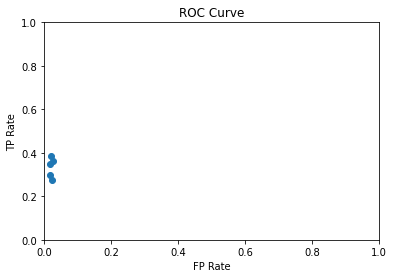

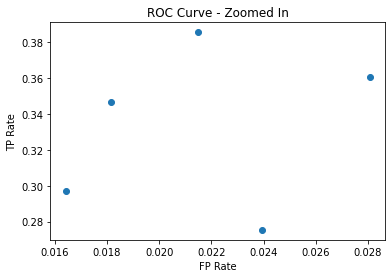

5-Fold Cross Validation score: 0.7583873290136789
########################## NAIVE BAYES COMPLETE ############################



In [ ]:
# Naive Bayes testing
features = ['koi_period', 'koi_prad', 'koi_model_snr']

n_bayes = {'quantiles': 10,
           'additive smoothing': 3}
           
run_test_suite(df, features, nb=n_bayes)

Features Used:
	koi_period
	koi_impact
	koi_depth
	koi_prad
	koi_model_snr

Number of confirmed planets: 2363
Number of false positive instances: 4840
Number of candidate planets: 2361

##################### RUNNING KNN #####################
Model 1, k=9:
	Accuracy: 0.8401727861771058
	Precision: 0.7744034707158352
	Recall: 0.751578947368421

Confusion Matrix: [[357, 118],
                   [104, 810]]

Model 2, k=9:
	Accuracy: 0.8725701943844493
	Precision: 0.8090128755364807
	Recall: 0.810752688172043

Confusion Matrix: [[377, 88],
                   [89, 835]]

Model 3, k=9:
	Accuracy: 0.871130309575234
	Precision: 0.8095238095238095
	Recall: 0.8043010752688172

Confusion Matrix: [[374, 91],
                   [88, 836]]

Model 4, k=9:
	Accuracy: 0.8509719222462203
	Precision: 0.7983539094650206
	Recall: 0.7806841046277666

Confusion Matrix: [[388, 109],
                   [98, 794]]

Model 5, k=9:
	Accuracy: 0.8761699064074874
	Precision: 0.8172484599589322
	Recall: 0.827442827442

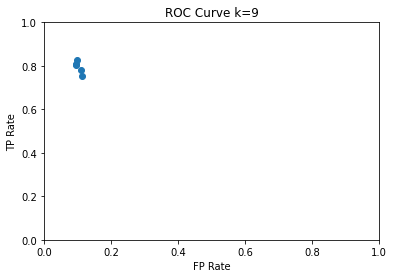

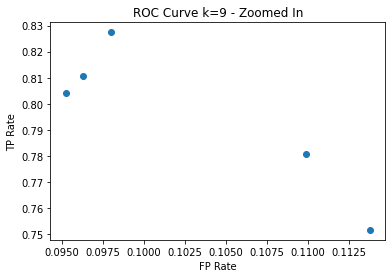

5-Fold Cross Validation score k=9: 0.8622030237580993
########################## KNN COMPLETE ############################



In [ ]:
# KNN testing
features = ['koi_period', 'koi_impact', 'koi_depth', 'koi_prad', 'koi_model_snr']

# pass kmin, kmax
k_range = (9, 9)

run_test_suite(df, features, k_range=k_range)

Features Used:
	koi_period
	koi_impact
	koi_duration
	koi_depth
	koi_prad
	koi_model_snr

Number of confirmed planets: 2363
Number of false positive instances: 4840
Number of candidate planets: 2361

##################### TESTING DECISION TREE #####################
Model 1:
	Accuracy: 0.8740100791936645
	Precision: 0.788135593220339
	Recall: 0.8322147651006712

Confusion Matrix: [[372, 75],
                   [100, 842]]

Model 2:
	Accuracy: 0.8790496760259179
	Precision: 0.8273684210526315
	Recall: 0.8204592901878914

Confusion Matrix: [[393, 86],
                   [82, 828]]

Model 3:
	Accuracy: 0.8790496760259179
	Precision: 0.8503118503118503
	Recall: 0.80990099009901

Confusion Matrix: [[409, 96],
                   [72, 812]]

Model 4:
	Accuracy: 0.8603311735061195
	Precision: 0.7863070539419087
	Recall: 0.8063829787234043

Confusion Matrix: [[379, 91],
                   [103, 816]]

Model 5:
	Accuracy: 0.8740100791936645
	Precision: 0.8407079646017699
	Recall: 0.78674948240165

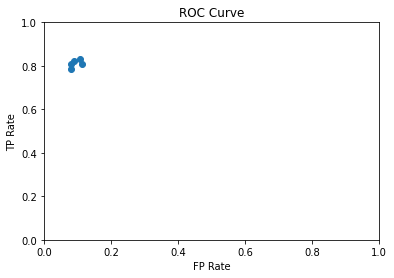

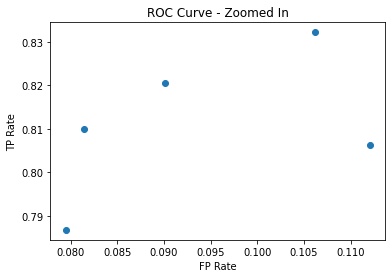

5-Fold Cross Validation score: 0.873290136789057
##################### DECISION TREE COMPLETE ####################



In [ ]:
# Decision tree testing
features = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_model_snr']

# turn on or off, True=on, None=off
tree_model = True

run_test_suite(df, features, tree_model=tree_model)

Features Used:
	koi_period
	koi_impact
	koi_duration
	koi_depth
	koi_prad
	koi_model_snr

Number of confirmed planets: 2363
Number of false positive instances: 4840
Number of candidate planets: 2361

##################### TESTING RANDOM FOREST #####################
Model 1:
	Accuracy: 0.91792656587473
	Precision: 0.8857142857142857
	Recall: 0.8821138211382114

Confusion Matrix: [[434, 58],
                   [56, 841]]

Model 2:
	Accuracy: 0.9092872570194385
	Precision: 0.8525641025641025
	Recall: 0.875

Confusion Matrix: [[399, 57],
                   [69, 864]]

Model 3:
	Accuracy: 0.9107271418286537
	Precision: 0.8617021276595744
	Recall: 0.8728448275862069

Confusion Matrix: [[405, 59],
                   [65, 860]]

Model 4:
	Accuracy: 0.9143268538516919
	Precision: 0.8822269807280514
	Recall: 0.865546218487395

Confusion Matrix: [[412, 64],
                   [55, 858]]

Model 5:
	Accuracy: 0.9380849532037437
	Precision: 0.9100642398286938
	Recall: 0.906183368869936

Confusion Ma

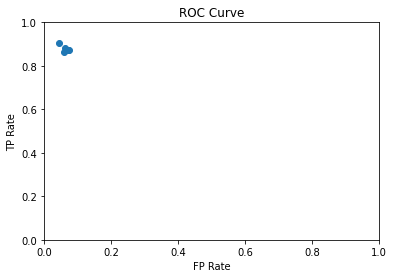

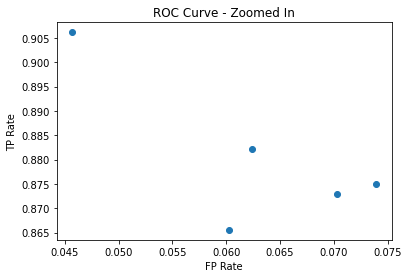

5-Fold Cross Validation score: 0.9180705543556515
##################### RANDOM FOREST COMPLETE ####################



In [ ]:
# Random Forest testing
features = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_model_snr']

# pass number of trees and max depth in dict
forest_model = {'n_estimators': 30, 'max_depth': 100}

run_test_suite(df, features, forest_model=forest_model)

Features Used:
	koi_period
	koi_impact
	koi_depth
	koi_prad
	koi_model_snr

Number of confirmed planets: 2363
Number of false positive instances: 4840
Number of candidate planets: 2361

##################### PRINCIPLE COMPONENT ANALYSIS #####################


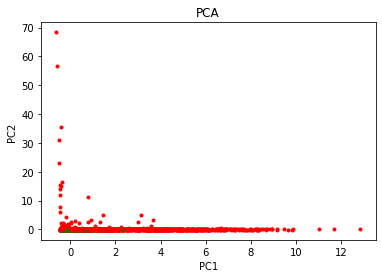

############################## PCA COMPLETE ############################

##################### PRINCIPLE COMPONENT ANALYSIS 3D #####################


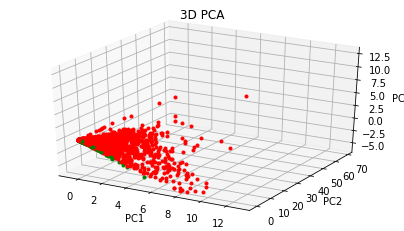

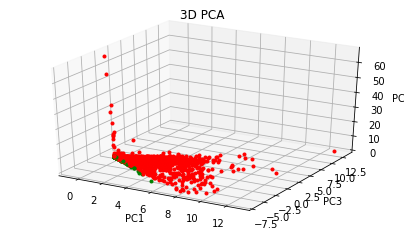

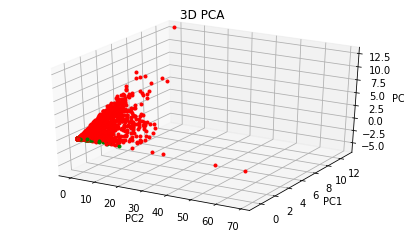

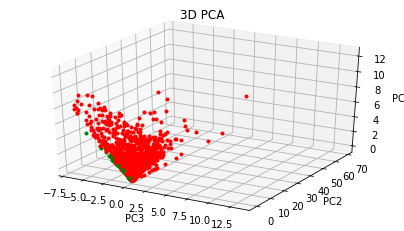

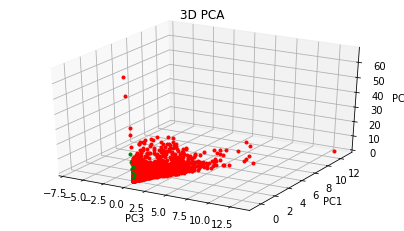

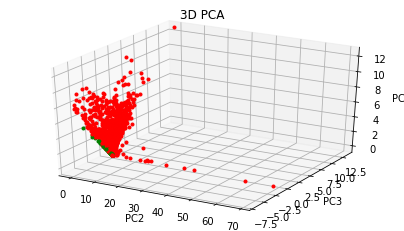

############################## PCA 3D COMPLETE ############################



In [ ]:
# PCA testing
features = ['koi_period', 'koi_impact', 'koi_depth', 'koi_prad', 'koi_model_snr']

# pass step size through points to plot
pca = 0.01

# pass step size through points to plot
pca3d = 0.01

run_test_suite(df, features, pca=pca, pca3d=pca3d)

Features Used:
	koi_period
	koi_impact
	koi_duration
	koi_depth
	koi_prad
	koi_model_snr

Number of confirmed planets: 2363
Number of false positive instances: 4840
Number of candidate planets: 2361

##################### TESTING MLP 5-FOLD CV #####################
Model 1:
	Accuracy: 0.91792656587473
	Precision: 0.9019607843137255
	Recall: 0.8571428571428571

Confusion Matrix: [[414, 69],
                   [45, 861]]



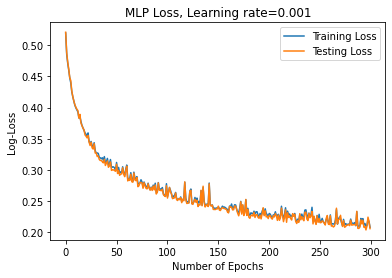

Model 2:
	Accuracy: 0.9193664506839453
	Precision: 0.9240506329113924
	Recall: 0.8521400778210116

Confusion Matrix: [[438, 76],
                   [36, 839]]



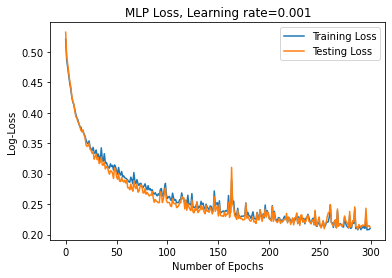

Model 3:
	Accuracy: 0.8869690424766019
	Precision: 0.8063157894736842
	Recall: 0.8549107142857143

Confusion Matrix: [[383, 65],
                   [92, 849]]



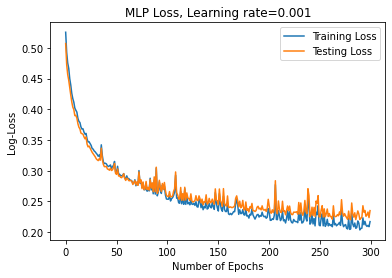

Model 4:
	Accuracy: 0.8970482361411087
	Precision: 0.8220338983050848
	Recall: 0.8680089485458613

Confusion Matrix: [[388, 59],
                   [84, 858]]



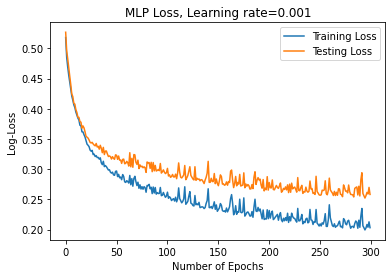

Model 5:
	Accuracy: 0.9078473722102232
	Precision: 0.8713692946058091
	Recall: 0.8641975308641975

Confusion Matrix: [[420, 66],
                   [62, 841]]



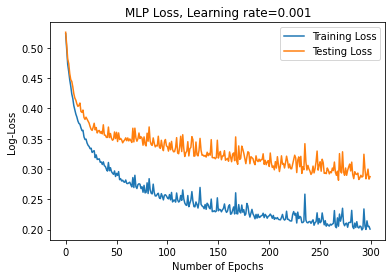

ROC Curves


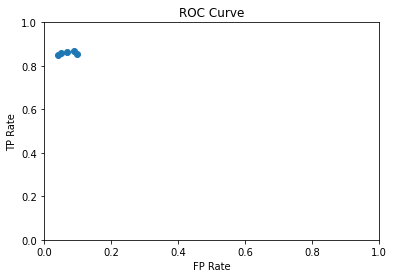

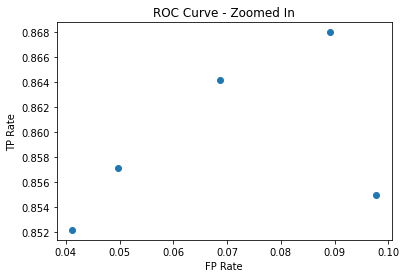

5-Fold Cross Validation Score: 0.9058315334773217
Model with highest accuracy: 0.9193664506839453

Medium confidence (above 95%) in 85 planets
High confidence (above 99%) in 20 planets
Full confidence (above 99.9%) in 4 planets
##################### MLP TESTING COMPLETE ######################



In [ ]:
# sklearn MLP Testing
features = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_model_snr']

# pass model and epochs in dict
mlp_model = {'network architecture': [7500], 'epochs': 300}

run_test_suite(df, features, mlp_model=mlp_model)

Features Used:
	koi_period
	koi_impact
	koi_duration
	koi_depth
	koi_prad
	koi_model_snr

Number of confirmed planets: 2363
Number of false positive instances: 4840
Number of candidate planets: 2361

#################### RUNNING TENSORFLOW TEST ####################
Model 1:
	Accuracy: 0.893448531627655
	Precision: 0.800718132854578
	Recall: 0.9233954451345756

Confusion Matrix: [[446, 37],
                   [111, 795]]



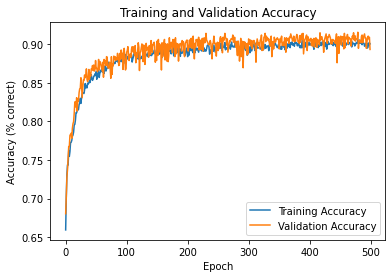

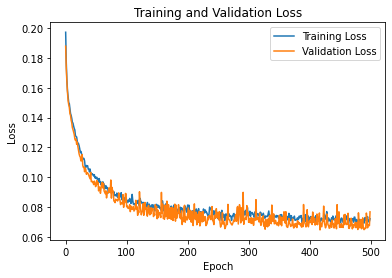

Model 2:
	Accuracy: 0.8603311777114868
	Precision: 0.9137466307277629
	Recall: 0.6766467065868264

Confusion Matrix: [[339, 162],
                   [32, 856]]



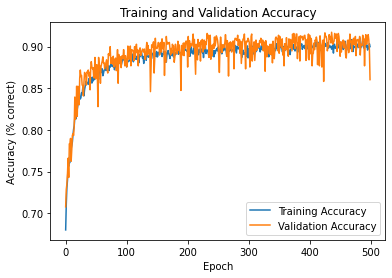

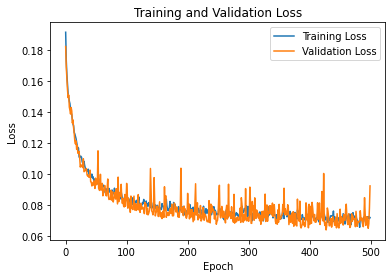

Model 3:
	Accuracy: 0.9136068820953369
	Precision: 0.8355640535372849
	Recall: 0.9278131634819533

Confusion Matrix: [[437, 34],
                   [86, 832]]



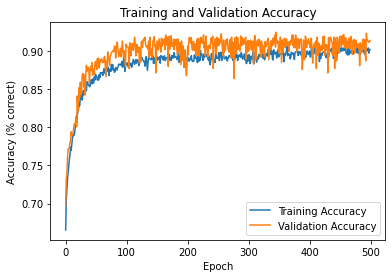

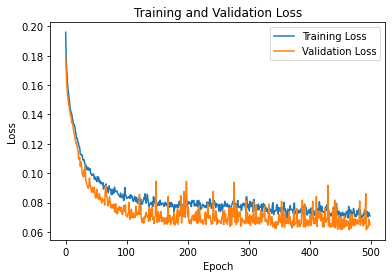

Model 4:
	Accuracy: 0.8970482349395752
	Precision: 0.8508771929824561
	Recall: 0.838012958963283

Confusion Matrix: [[388, 75],
                   [68, 858]]



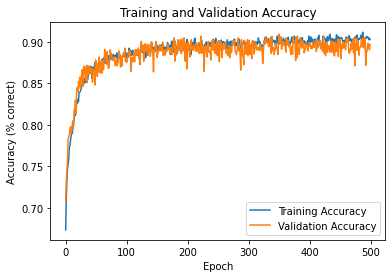

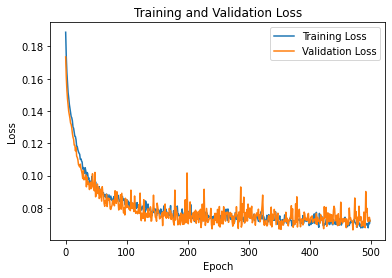

Model 5:
	Accuracy: 0.8948884010314941
	Precision: 0.9093406593406593
	Recall: 0.7454954954954955

Confusion Matrix: [[331, 113],
                   [33, 912]]



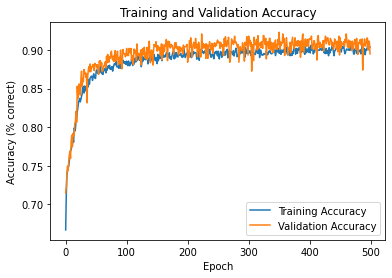

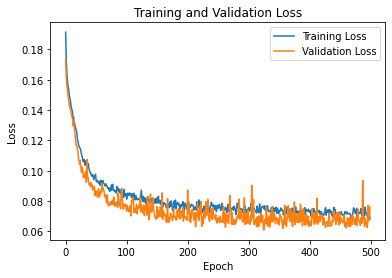

ROC Curves


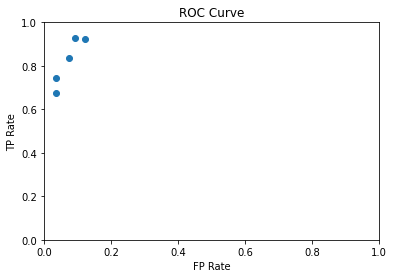

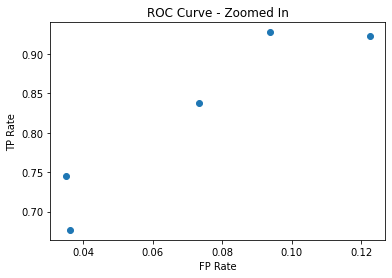

Tensorflow Model Accuracy: 0.8918646454811097

Model with highest accuracy: 0.9136068820953369

Medium confidence (above 95%) in 97 planets
High confidence (above 99%) in 14 planets
Full confidence (above 99.9%) in 8 planets
#################### TENSORFLOW TEST COMPLETE ###################



In [ ]:
# Tensorflow neural network testing

features = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_model_snr']

model = Sequential([
    layers.Dense(50, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(50, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid"),
])

tf_model = {
    'model': model,
    'epochs': 500
}

run_test_suite(df, features, tf_model=tf_model)